In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import chisquare
from scipy.signal import savgol_filter
import seaborn as sn
import math
from sklearn.preprocessing import normalize

## RLC time domain analysis: damped harmonic oscillator

### Visualization of experimental data and relative uncertainties

In [ ]:
data = pd.read_excel(r'RLC_tV.xlsx')
print(data)

                 t   ch1   ch2
0     7.000000e-07  1.00  1.94
1     8.000000e-07  1.00  1.94
2     9.000000e-07  1.00  1.94
3     1.000000e-06  0.98  1.94
4     1.100000e-06  0.98  1.94
...            ...   ...   ...
2418  2.425000e-04  1.04 -0.02
2419  2.426000e-04  1.04 -0.02
2420  2.427000e-04  1.04 -0.02
2421  2.428000e-04  1.04 -0.02
2422  2.429000e-04  1.04 -0.02

[2423 rows x 3 columns]


In [ ]:
sigma_ch1 = (0.02**2+(0.015*data["ch1"])**2)**0.5       #First channel uncertainty
sigma = (0.02**2+(0.015*data["ch2"])**2)**0.5           #Second channel uncertainty

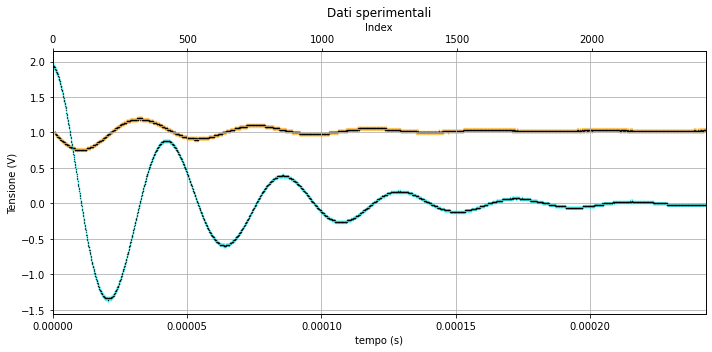

In [ ]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 5)
ax1.grid()

ax1.set_xlabel('tempo (s)')
ax1.set_ylabel('Tensione (V)')

ax1.fill_between(data["t"], data["ch1"]+sigma_ch1, data["ch1"]-sigma_ch1, color="orange", alpha=0.5)
ax1.scatter(data["t"], data["ch1"], s=0.1, color="black")
ax1.tick_params(axis='y')
ax1.set_xlim(0, data["t"][2422])


ax2 = ax1.twiny()  
ax2.set_xlabel('Index')  

ax2.fill_between(np.arange(len(data["t"])), data["ch2"]+sigma, data["ch2"]-sigma, color="cyan", alpha=0.5)
ax2.scatter(np.arange(len(data["t"])), data["ch2"], s=0.1, color="black")
ax2.tick_params(axis='x')
ax2.set_xlim(0, 2422)

plt.title("Dati sperimentali")
fig.tight_layout()
plt.show()

0.021055688144259906
0.02005617112013158


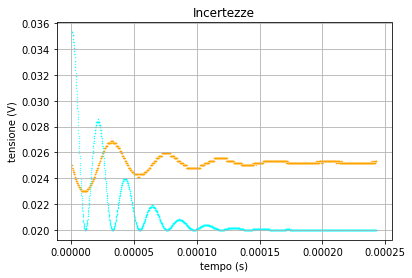

In [ ]:
plt.figure()
plt.grid()
plt.scatter(data["t"], sigma_ch1, s=0.1, color="orange")
plt.scatter(data["t"], sigma, s=0.1, color="cyan")
plt.xlabel("tempo (s)")
plt.ylabel("tensione (V)")
plt.title("Incertezze")
print(sigma.mean())
print(sigma.median())

### Analytical model fit

In [ ]:
#Using V_0 = 2 V
def v(x, d, w):
  s = (w**2-d**2)**0.5
  return 2*np.e**(-d*x)*(-d*np.sin(x*s)+s*np.cos(x*s))/s

def chi2(x, y, d, w):
  return np.sum((v(x, d, w)-y)**2/sigma**2)
vchi2 = np.vectorize(chi2)

def chi2_a(d, w):
  return np.sum((v(data["t"], d, w)-data["ch2"])**2/sigma**2)
vchi2_a = np.vectorize(chi2_a)

def sigma_post(x, y, d, w):
  sum = 0
  for i in range(len(x)):
    sum += (v(x[i], d, w)-y[i])**2
  return (sum/(len(x)-2))**0.5

def c_lambda(x, y, s_x, s_y):
  d = (s_x**2+s_y**2)**0.5
  return np.abs(x-y)/d

In [ ]:
popt, pcov = curve_fit(v, data["t"], data["ch2"], p0=[2.5*10**4, 2.3*10**5], sigma=sigma, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
print("d = " + str(popt[0]) + " \pm " + str(perr[0]))
print("w = " + str(popt[1]) + " \pm " + str(perr[1]))

s_post = sigma_post(data["t"], data["ch2"], popt[0], popt[1])
print("s_post = " + str(s_post))
print("chi2 = " + str(chi2(data["t"], data["ch2"], popt[0], popt[1])))

d = 18693.28214841401 \pm 24.775928192006287
w = 142831.90861374154 \pm 23.580442952555625
s_post = 0.06628979936486332
chi2 = 21063.76283129089


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


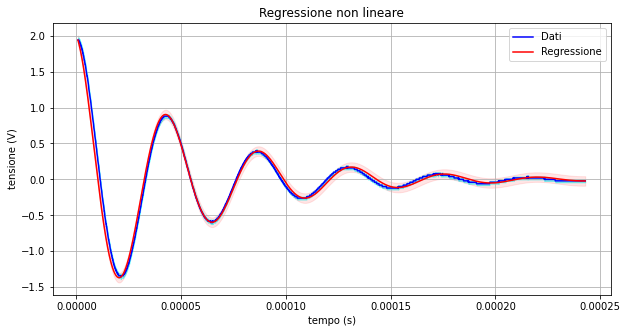

In [ ]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(data["t"], data["ch2"], color="blue", label="Dati")
plt.fill_between(data["t"], data["ch2"]+sigma, data["ch2"]-sigma, color="cyan", alpha=0.5)

y_fit = v(data["t"], popt[0], popt[1])
plt.plot(data["t"], y_fit, color="red", label="Regressione")
plt.fill_between(data["t"], y_fit+s_post, y_fit-s_post, color="red", alpha=0.1)
plt.title("Regressione non lineare")
plt.xlabel("tempo (s)")
plt.ylabel("tensione (V)")
plt.legend()

Text(0, 0.5, 'frequenza assoluta')

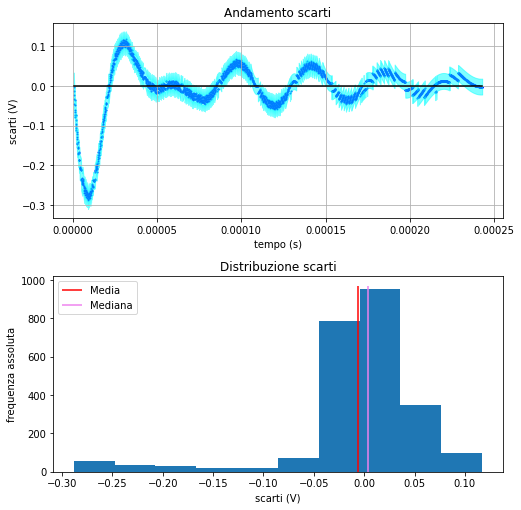

In [ ]:
scarti = v(data["t"], popt[0], popt[1])-data["ch2"]
#s_scarti = (sigma**2+s_post**2)**0.5
s_scarti = (sigma**2)**0.5


plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.9, top=0.9, wspace=0.2,hspace=0.3)

plt.subplot(211)
plt.grid()
plt.plot([data["t"][0], data["t"][2422]], [0, 0], color="black")
plt.scatter(data["t"], scarti, s=1, color="blue")
plt.fill_between(data["t"], scarti+s_scarti, scarti-s_scarti, color="cyan", alpha=0.5)
plt.title("Andamento scarti")
plt.xlabel("tempo (s)")
plt.ylabel("scarti (V)")

plt.subplot(212)
plt.hist(scarti)
plt.vlines(scarti.mean(), 0, 970, color="red", label="Media")
plt.vlines(scarti.median(), 0, 970, color="violet", label="Mediana")
plt.legend(loc="upper left")
plt.title("Distribuzione scarti")
plt.xlabel("scarti (V)")
plt.ylabel("frequenza assoluta")

Text(0, 0.5, '$\\delta$ (Hz)')

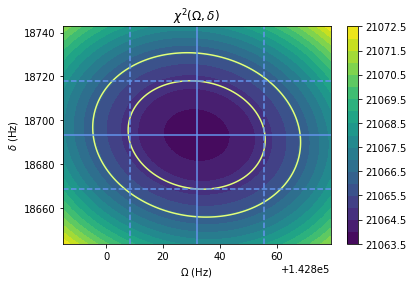

In [ ]:
chi2_min = chi2(data["t"], data["ch2"], popt[0], popt[1])

d = np.linspace(popt[0]-2*perr[0], popt[0]+2*perr[0], 100)
w = np.linspace(popt[1]-2*perr[1], popt[1]+2*perr[1], 100)

W, D = np.meshgrid(w, d)
Z = vchi2_a(D, W)

plt.figure()
plt.contourf(W, D, Z, 20, cmap="viridis")
plt.colorbar()
plt.contour(W, D, Z, 100, cmap="Wistia", levels = [chi2_min +2.3])
plt.contour(W, D, Z, 100, cmap="Wistia", levels = [chi2_min +1])

plt.vlines(popt[1], d.min(), d.max(), color="cornflowerblue")
plt.vlines(popt[1]+perr[1], d.min(), d.max(), ls="--", color="cornflowerblue")
plt.vlines(popt[1]-perr[1], d.min(), d.max(), ls="--", color="cornflowerblue")
plt.hlines(popt[0], w.min(), w.max(), color="cornflowerblue")
plt.hlines(popt[0]+perr[0], w.min(), w.max(), ls="--", color="cornflowerblue")
plt.hlines(popt[0]-perr[0], w.min(), w.max(), ls="--", color="cornflowerblue")

plt.title("$\chi^2(\Omega, \delta)$")
plt.xlabel("$\Omega$ (Hz)")
plt.ylabel("$\delta$ (Hz)")

### Smooth curve



d = 18693.023093841733 \pm 24.77538882057099
lambda-compatibilità con stima precedente: 0.007393516692913696
w = 142831.8039108261 \pm 23.579951522699446
lambda-compatibilità con stima precedente: 0.0031397592127781968




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


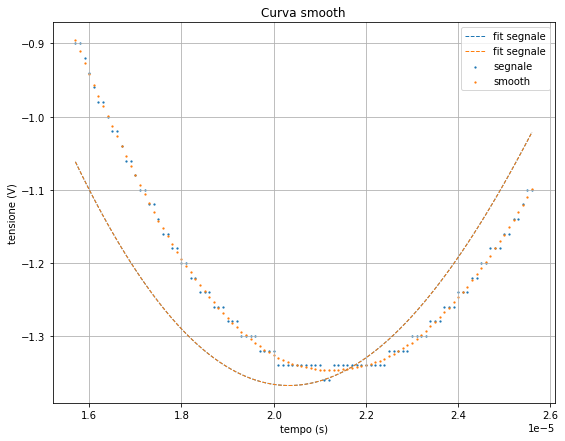

In [ ]:
y_smooth = savgol_filter(data["ch2"], 35, 2) #smoothing

popt_s, pcov_s = curve_fit(v, data["t"], y_smooth, p0=[2.5*10**4, 2.3*10**5], sigma=sigma, absolute_sigma=True)
perr_s = np.sqrt(np.diag(pcov_s))
print("\n")
print("d = " + str(popt_s[0]) + " \pm " + str(perr_s[0]))
print("lambda-compatibilità con stima precedente: " + str(c_lambda(popt[0], popt_s[0], perr[0], perr_s[0])))
print("w = " + str(popt_s[1]) + " \pm " + str(perr_s[1]))
print("lambda-compatibilità con stima precedente: " + str(c_lambda(popt[1], popt_s[1], perr[1], perr_s[1])))
print("\n")

plt.figure(figsize=(9, 7))
plt.grid()
plt.scatter(data["t"][150:250], data["ch2"][150:250], s=1.5, label="segnale")
plt.scatter(data["t"][150:250], y_smooth[150:250], s=1.5, label="smooth")
plt.plot(data["t"][150:250], v(data["t"], popt[0], popt[1])[150:250], lw=1, linestyle="--",  label="fit segnale")
plt.plot(data["t"][150:250], v(data["t"], popt_s[0], popt_s[1])[150:250], lw=1, linestyle="--", label="fit segnale")

plt.title("Curva smooth")
plt.xlabel("tempo (s)")
plt.ylabel("tensione (V)")
plt.legend()

### 5-parameters fit

parametri: [ 2.01155105e+00 -1.45323180e+05  1.64543349e+00  1.88589218e+04
 -4.99905565e-03]
incertezze: [8.62925537e-04 1.17953342e+01 4.59352937e-04 1.12102514e+01
 1.40278515e-04]



Text(0, 0.5, 'tensione (V)')

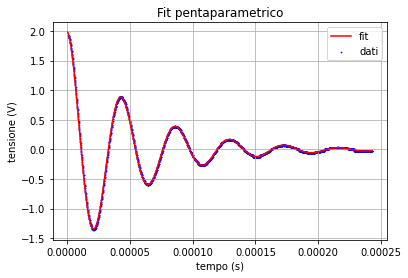

In [ ]:
def f(x, a, b, c, d, e):
  return a*np.e**(-d*x)*np.sin(x*b+c) + e

popt_p, pcov_p = curve_fit(f, data["t"], data["ch2"])
perr_p = np.sqrt(np.diag(pcov_p))
print("parametri: " + str(popt_p))
print("incertezze: " + str(perr_p) + "\n")

plt.figure()
plt.grid()
x = np.linspace(0, 10, 10000)
plt.plot(data["t"], f(data["t"], popt_p[0], popt_p[1], popt_p[2], popt_p[3], popt_p[4]), color="red", label="fit")
plt.scatter(data["t"], data["ch2"], color="blue", label="dati", s=0.5)

plt.legend()
plt.title("Fit pentaparametrico")
plt.xlabel("tempo (s)")
plt.ylabel("tensione (V)")

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0, 0.5, 'frequenza assoluta')

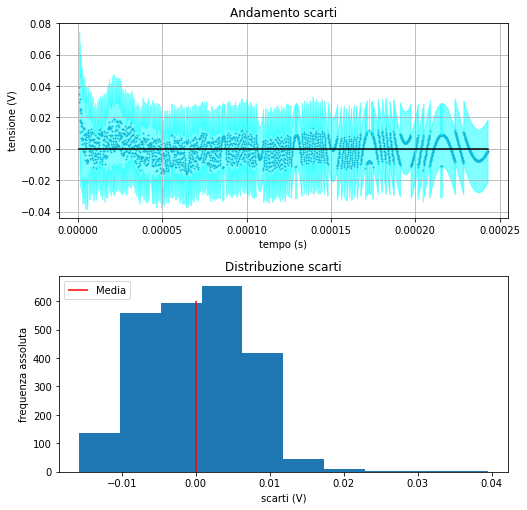

In [ ]:
scarti_p = f(data["t"], popt_p[0], popt_p[1], popt_p[2], popt_p[3], popt_p[4])-data["ch2"]

plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.9, top=0.9, wspace=0.2,hspace=0.3)

plt.subplot(211)
plt.grid()
plt.plot([data["t"][0], data["t"][-1:]], [0, 0], color="black")
plt.scatter(data["t"], scarti_p, s=1)
plt.fill_between(data["t"], scarti_p+sigma, scarti_p-sigma, color="cyan", alpha=0.5)
plt.xlabel("tempo (s)")
plt.ylabel("tensione (V)")
plt.title("Andamento scarti")

plt.subplot(212)
plt.hist(scarti_p)
plt.vlines(scarti_p.mean(), 0, 600, color="red", label="Media")
plt.legend(loc="upper left")
plt.title("Distribuzione scarti")
plt.xlabel("scarti (V)")
plt.ylabel("frequenza assoluta")

In [ ]:
def chi2_p(x, y, a, b, c, d, e):
  return np.sum((f(x, a, b, c, d, e)-y)**2/sigma**2)
  
print("chi2 = " + str(chi2_p(data["t"], data["ch2"], popt_p[0], popt_p[1], popt_p[2], popt_p[3], popt_p[4])))

chi2 = 240.59873264129362


### Minuit

In [ ]:
#!pip install iminuit matplotlib numpy
from iminuit import Minuit

m = Minuit(chi2_a, d=2.5*10**4, w=2.3*10**5)
m.migrad()

print("d = " + str(m.values[0]) + " \pm " + str(m.errors[0]))
print("lambda-compatibilità con stima precedente: " + str(c_lambda(popt[0], m.values[0], perr[0], m.errors[0])))
print("w = " + str(m.values[1]) + " \pm " + str(m.errors[0]))
print("lambda-compatibilità con stima precedente: " + str(c_lambda(popt[1], m.values[1], perr[1], m.errors[0])))

d = 18693.300792935377 \pm 24.700384275604982
lambda-compatibilità con stima precedente: 0.0005329278381698904
w = 142831.86607124613 \pm 24.700384275604982
lambda-compatibilità con stima precedente: 0.001245794606675961


### Head and Tail

In [ ]:
#Chi2 normalizzato
def chi2_n(x, y, d, w):
  chi = np.sum((v(x, d, w)-y)**2/sigma**2)
  return chi/(len(x)-2)

In [ ]:
chi2_h_a = np.array([]) #chi2 su tutto il set
chi2_h_b = np.array([]) #chi2 sul set piccolo
for i in range(len(data["t"])-5):
  head_n = data[:i+5]
  popt_h_n, pcov_h_n = curve_fit(v, head_n["t"], head_n["ch2"], p0=[2.5*10**4, 2.3*10**5], sigma=sigma[:i+5], absolute_sigma=True)
  chi2_h_a = np.append(chi2_h_a, chi2_n(data["t"], data["ch2"], popt_h_n[0], popt_h_n[1]))
  chi2_h_b = np.append(chi2_h_b, chi2_n(data["t"][:i+5], data["ch2"][:i+5], popt_h_n[0], popt_h_n[1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
chi2_t_a = np.array([]) #chi2 su tutto il set
chi2_t_b = np.array([]) #chi2 sul set piccolo
for i in range(len(data["t"])-5):
  tail_n = data[2417-i:]
  popt_t_n, pcov_t_n = curve_fit(v, tail_n["t"], tail_n["ch2"], p0=[2.5*10**4, 2.3*10**5], sigma=sigma[2417-i:], absolute_sigma=True)
  chi2_t_a = np.append(chi2_t_a, chi2_n(data["t"], data["ch2"], popt_t_n[0], popt_t_n[1]))
  chi2_t_b = np.append(chi2_t_b, chi2_n(data["t"][2417-i:], data["ch2"][2417-i:], popt_t_n[0], popt_t_n[1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


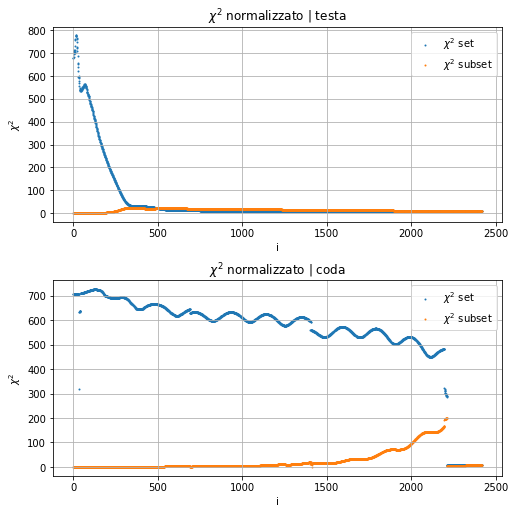

In [ ]:
x = np.arange(len(data["t"])-5)
plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.9, top=0.9, wspace=0.2,hspace=0.3)

plt.subplot(211)
plt.grid()
plt.scatter(x, chi2_h_a, s=1, label="$\chi^2$ set")
plt.scatter(x, chi2_h_b, s=1, label="$\chi^2$ subset")

plt.title("$\chi^2$ normalizzato | testa")
plt.xlabel("i")
plt.ylabel("$\chi^2$")
plt.legend()


plt.subplot(212)
plt.grid()
plt.scatter(x, chi2_t_a, s=1, label="$\chi^2$ set")
plt.scatter(x, chi2_t_b, s=1, label="$\chi^2$ subset")

plt.title("$\chi^2$ normalizzato | coda")
plt.xlabel("i")
plt.ylabel("$\chi^2$")
plt.legend()

## RLC frequency domain analysis: resonance curve

### Visualization of experimental data and relative uncertainties

In [ ]:
data = pd.read_excel(r'RLC_fV.xlsx')
div_in = 0.5 #V
div_out = 0.1 #V
data.tail()

,f,Vin,Vout
26,28.0,1.72,0.220
27,29.0,1.78,0.196
28,30.0,1.82,0.180
29,31.0,1.86,0.164
30,35.0,1.94,0.124


In [ ]:
s_in = ((0.04*div_in)**2+(0.015*data["Vin"])**2)**0.5
s_out = ((0.04*div_out)**2+(0.015*data["Vout"])**2)**0.5

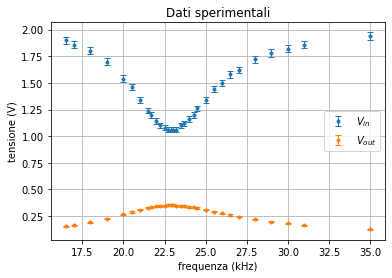

In [ ]:
plt.figure()
plt.errorbar(data["f"], data["Vin"], s_in, fmt='.', elinewidth=1, capsize = 3, label="$V_{in}$")
plt.errorbar(data["f"], data["Vout"], s_out, fmt='.', elinewidth=1, capsize = 3, label="$V_{out}$")

plt.grid()
plt.xlabel("frequenza (kHz)")
plt.ylabel("tensione (V)")
plt.title("Dati sperimentali")
plt.legend()

### Analytical model fit

In [ ]:
V = data["Vout"]/data["Vin"]

sigma = (data["Vout"]/data["Vin"])*((0.04*div_in/data["Vin"])**2+(0.04*div_out/data["Vout"])**2+2*(0.012)**2)**0.5

In [ ]:
X = 2*np.pi*data["f"] #Conversione alle pulsazioni

In [ ]:
def T(x, a, o, d):
  den = (x**4-2*x**2*(o**2-2*d**2)+o**4)**0.5
  return a*x/den
vT = np.vectorize(T)

def chi2(x, y, a, o, d):
  return np.sum((T(x, a, o, d)-y)**2/sigma**2)
vchi2 = np.vectorize(chi2)

In [ ]:
popt, pcov = curve_fit(T, X, V, p0=[1, 140, 10], sigma=sigma, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))

print("a = " + str(popt[0]) + " \pm " + str(perr[0]))
print("o = " + str(popt[1]) + " \pm " + str(perr[1]))
print("d = " + str(popt[2]) + " \pm " + str(perr[2]))

a = 7.996713263015596 \pm 0.07345360394143084
o = 144.04111020204886 \pm 0.16022227150388374
d = 12.059853555284814 \pm 0.1811256334137736


In [ ]:
chi2_min = chi2(X, V, popt[0], popt[1], popt[2])
print("chi2 minimo = " + str(chi2_min))

chi2 minimo = 2.871096516081722


Text(0.5, 1.0, 'Funzione di trasferimento')

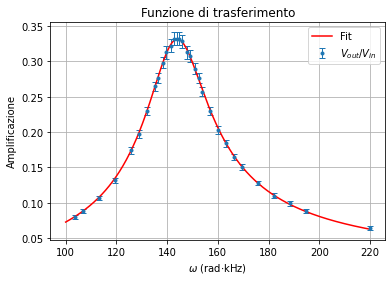

In [ ]:
plt.figure()
plt.scatter(X, V, s=2)
plt.errorbar(X, V, sigma, fmt='.', elinewidth=1, capsize = 3, label="$V_{out}/V_{in}$")
plt.plot(np.linspace(100, 220, 1000), T(np.linspace(100, 220, 1000), popt[0], popt[1], popt[2]), label="Fit", color="red")

plt.grid()
plt.legend()
plt.xlabel("$\omega$ (rad$\cdot$kHz)")
plt.ylabel("Amplificazione")
plt.title("Funzione di trasferimento")

Text(0.5, 1.0, 'Distribuzione scarti')

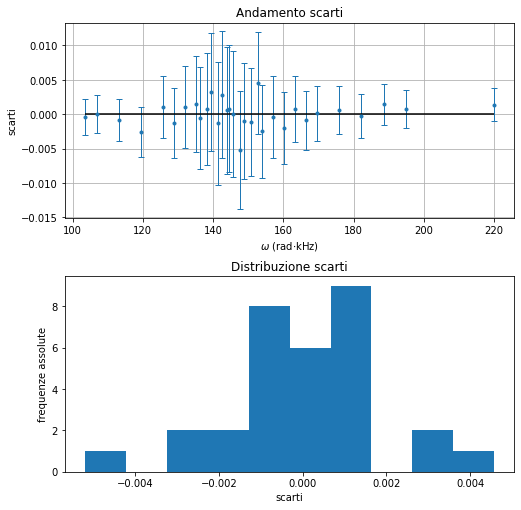

In [ ]:
scarti = V - T(X, popt[0], popt[1], popt[2])

plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.9, top=0.9, wspace=0.2,hspace=0.3)

plt.subplot(211)
plt.errorbar(X, scarti, sigma, fmt='.', elinewidth=1, capsize = 3, label="scarti")
plt.hlines(0, X.min(), X.max())
plt.xlabel("$\omega$ (rad$\cdot$kHz)")
plt.ylabel("scarti")
plt.title("Andamento scarti")
plt.grid()

plt.subplot(212)
plt.hist(scarti)
plt.xlabel("scarti")
plt.ylabel("frequenze assolute")
plt.title("Distribuzione scarti")

### Profiled $\chi^2$

In [ ]:
a = np.linspace(popt[0]-2*perr[0], popt[0]+2*perr[0], 100)
o = np.linspace(popt[1]-2*perr[1], popt[1]+2*perr[1], 100) 
d = np.linspace(popt[2]-2*perr[2], popt[2]+2*perr[2], 100)

O, D = np.meshgrid(o, d)
O, A = np.meshgrid(o, a)
D, A = np.meshgrid(d, a)

In [ ]:
def chi2_pa(o, d):
  chi2a = np.array([])
  for i in a:
    chi2a = np.append(chi2a, chi2(X, V, i, o, d))
  return np.min(chi2a)
vchi2_pa = np.vectorize(chi2_pa)

def chi2_pd(o, a):
  chi2d = np.array([])
  for i in d:
    chi2d = np.append(chi2d, chi2(X, V, a, o, i))
  return np.min(chi2d)
vchi2_pd = np.vectorize(chi2_pd)

def chi2_po(d, a):
  chi2o = np.array([])
  for i in o:
    chi2o = np.append(chi2o, chi2(X, V, a, i, d))
  return np.min(chi2o)
vchi2_po = np.vectorize(chi2_po)

In [ ]:
%%time
Z = vchi2_pa(O, D)  
np.save("OD", Z)

CPU times: user 31min 27s, sys: 22.4 s, total: 31min 49s
Wall time: 31min 27s


In [ ]:
%%time
K = vchi2_pd(O, A)
np.save("OA", K)

CPU times: user 30min 16s, sys: 22.7 s, total: 30min 38s
Wall time: 30min 15s


In [ ]:
%%time
J = vchi2_po(D, A)
np.save("DA", J)

CPU times: user 30min 14s, sys: 23.2 s, total: 30min 37s
Wall time: 30min 14s


Text(0, 0.5, 'A')

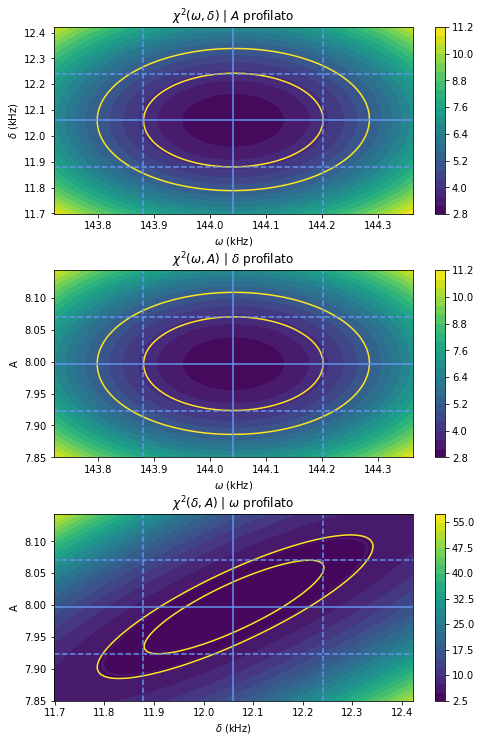

In [ ]:
plt.figure(figsize=(8, 12))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.9, top=0.9, wspace=0.2,hspace=0.3)

plt.subplot(311)
OD = np.load("OD.npy")
O, D = np.meshgrid(o, d)

plt.contourf(O, D, OD, 20, cmap="viridis")
plt.colorbar()
plt.contour(O, D, OD, 1, cmap="viridis", levels = [chi2_min, chi2_min +2.3])
plt.contour(O, D, OD, 1, cmap="viridis", levels = [chi2_min, chi2_min +1])

plt.vlines(popt[1], d.min(), d.max(), color="cornflowerblue")
plt.vlines(popt[1]+perr[1], d.min(), d.max(), ls="--", color="cornflowerblue")
plt.vlines(popt[1]-perr[1], d.min(), d.max(), ls="--", color="cornflowerblue")
plt.hlines(popt[2], o.min(), o.max(), color="cornflowerblue")
plt.hlines(popt[2]+perr[2], o.min(), o.max(), ls="--", color="cornflowerblue")
plt.hlines(popt[2]-perr[2], o.min(), o.max(), ls="--", color="cornflowerblue")

plt.title("$\chi^2 (\omega, \delta)$ | $A$ profilato")
plt.xlabel("$\omega$ (kHz)")
plt.ylabel("$\delta$ (kHz)")


plt.subplot(312)
OA = np.load("OA.npy")
O, A = np.meshgrid(o, a)

plt.contourf(O, A, OA, 20, cmap="viridis")
plt.colorbar()
plt.contour(O, A, OA, 100, cmap="viridis", levels = [chi2_min, chi2_min +2.3])
plt.contour(O, A, OA, 100, cmap="viridis", levels = [chi2_min, chi2_min +1])

plt.vlines(popt[1], a.min(), a.max(), color="cornflowerblue")
plt.vlines(popt[1]+perr[1], a.min(), a.max(), ls="--", color="cornflowerblue")
plt.vlines(popt[1]-perr[1], a.min(), a.max(), ls="--", color="cornflowerblue")
plt.hlines(popt[0], o.min(), o.max(), color="cornflowerblue")
plt.hlines(popt[0]+perr[0], o.min(), o.max(), ls="--", color="cornflowerblue")
plt.hlines(popt[0]-perr[0], o.min(), o.max(), ls="--", color="cornflowerblue")

plt.title("$\chi^2 (\omega, A)$ | $\delta$ profilato")
plt.xlabel("$\omega$ (kHz)")
plt.ylabel("A")


plt.subplot(313)
DA = np.load("DA.npy")
D, A = np.meshgrid(d, a)

plt.contourf(D, A, DA, 20, cmap="viridis")
plt.colorbar()
plt.contour(D, A, DA, 100, cmap="viridis", levels = [chi2_min +2.25, chi2_min +2.35])
plt.contour(D, A, DA, 100, cmap="viridis", levels = [chi2_min, chi2_min +1])

plt.vlines(popt[2], a.min(), a.max(), color="cornflowerblue")
plt.vlines(popt[2]+perr[2], a.min(), a.max(), ls="--", color="cornflowerblue")
plt.vlines(popt[2]-perr[2], a.min(), a.max(), ls="--", color="cornflowerblue")
plt.hlines(popt[0], d.min(), d.max(), color="cornflowerblue")
plt.hlines(popt[0]+perr[0], d.min(), d.max(), ls="--", color="cornflowerblue")
plt.hlines(popt[0]-perr[0], d.min(), d.max(), ls="--", color="cornflowerblue")

plt.title("$\chi^2 (\delta, A)$ | $\omega$ profilato")
plt.xlabel("$\delta$ (kHz)")
plt.ylabel("A")

### From $\chi^2$ to probability density function

0.7460609603871906
0.7459824748631634
0.7320089092802222


Text(0, 0.5, 'A')

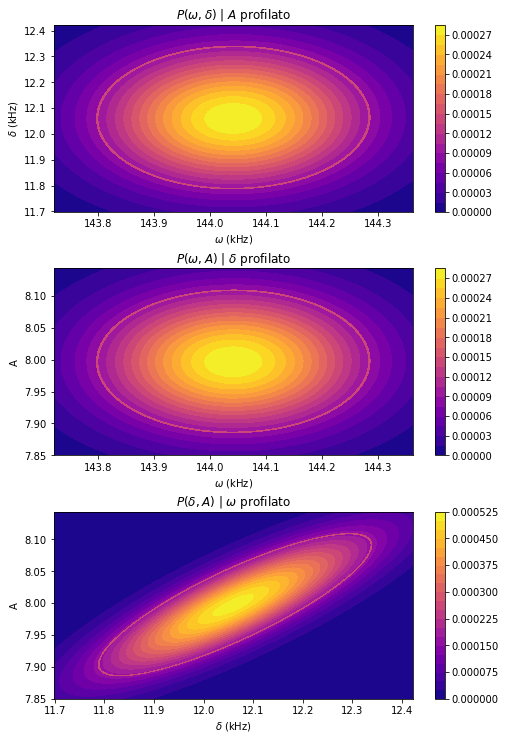

In [ ]:
plt.figure(figsize=(8, 12))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.9, top=0.9, wspace=0.2,hspace=0.3)

plt.subplot(311)
O, D = np.meshgrid(o, d)
P_d = np.exp(-(OD-chi2_min)/2)
P = P_d/P_d.sum()
p_min = np.exp(-(2.3/2))/P_d.sum()

plt.contourf(O, D, P, 20, cmap="plasma")
plt.colorbar()
plt.contourf(O, D, P, 100, cmap="plasma", levels = [p_min-0.000001, p_min+0.000001])

print(np.sum(P[P > p_min]))

plt.title("$P (\omega, \delta)$ | $A$ profilato")
plt.xlabel("$\omega$ (kHz)")
plt.ylabel("$\delta$ (kHz)")


plt.subplot(312)
O, A = np.meshgrid(o, a)
P_d = np.exp(-(OA-chi2_min)/2)
P = P_d/P_d.sum()
p_min = np.exp(-(2.3/2))/P_d.sum()

plt.contourf(O, A, P, 20, cmap="plasma")
plt.colorbar()
plt.contourf(O, A, P, 100, cmap="plasma", levels = [p_min-0.000001, p_min+0.000001])

print(np.sum(P[P > p_min]))

plt.title("$P (\omega, A)$ | $\delta$ profilato")
plt.xlabel("$\omega$ (kHz)")
plt.ylabel("A")


plt.subplot(313)
D, A = np.meshgrid(d, a)
P_d = np.exp(-(DA-chi2_min)/2)
P = P_d/P_d.sum()
p_min = np.exp(-(2.3/2))/P_d.sum()

plt.contourf(D, A, P, 20, cmap="plasma")
plt.colorbar()
plt.contourf(D, A, P, 100, cmap="plasma", levels = [p_min-0.000001, p_min+0.000001])


print(str(np.sum(P[P > p_min])))

plt.title("$P (\delta, A)$ | $\omega$ profilato")
plt.xlabel("$\delta$ (kHz)")
plt.ylabel("A")

 ### Pdf of one parameter

Prob o totale = 1.0 , attesa = 1
Prob o entro \pm sigma = 0.6832050104835251 , attesa = 0.68
Prob d totale = 1.0 , attesa = 1
Prob d entro \pm sigma = 0.6824380449367067 , attesa = 0.68
Prob a totale = 1.0 , attesa = 1
Prob a entro \pm sigma = 0.682539722981015 , attesa = 0.68


Text(0, 0.5, 'pdf')

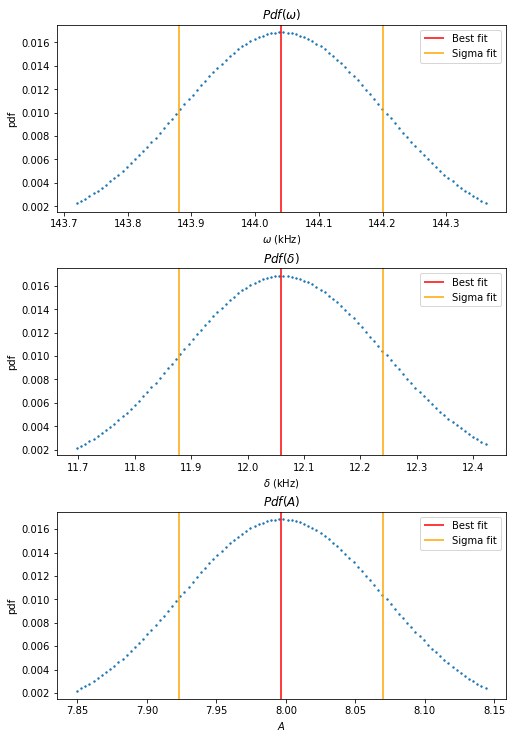

In [ ]:
plt.figure(figsize=(8, 12))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.9, top=0.9, wspace=0.2,hspace=0.3)

plt.subplot(311)
P_d = np.exp(-(OD-chi2_min)/2)      #From chi2 to pdf
P = P_d/P_d.sum()                   #Normalization
Po = P.sum(axis=0)                  #One-variable projection by adding along axis

dp = pd.DataFrame({"o" : o, "Po" : Po})                               #Create DataFrame to work with boolean filters
dp_r = dp[(dp["o"]>popt[1]-perr[1]) & (dp["o"]<popt[1]+perr[1])]      #DataFrame shrunk with only values inside \pm sigma
dp_r = dp_r.reset_index(drop=True)                                    #Reset reduced DataFrame index
print("Prob o totale = " + str(np.sum(dp["Po"])) + " , attesa = 1")          
print("Prob o entro \pm sigma = " + str(np.sum(dp_r["Po"])*0.95) + " , attesa = 0.68")

plt.ylim(0.0015, 0.0175)
plt.scatter(o, Po, s=2)
plt.vlines(popt[1], 0, 1, label="Best fit", color="red")
plt.vlines(popt[1]+perr[1], 0, 1, label="Sigma fit", color="orange")
plt.vlines(popt[1]-perr[1], 0, 1, color="orange")
plt.legend()

plt.title("$Pdf(\omega)$")
plt.xlabel("$\omega$ (kHz)")
plt.ylabel("pdf")


plt.subplot(312)
Pd = P.sum(axis=1)                  

dp = pd.DataFrame({"d" : d, "Pd" : Pd})                               
dp_r = dp[(dp["d"]>popt[2]-perr[2]) & (dp["d"]<popt[2]+perr[2])]      
dp_r = dp_r.reset_index(drop=True)                                    
print("Prob d totale = " + str(np.sum(dp["Pd"])) + " , attesa = 1")          
print("Prob d entro \pm sigma = " + str(np.sum(dp_r["Pd"])*0.95) + " , attesa = 0.68")

plt.ylim(0.0015, 0.0175)
plt.scatter(d, Pd, s=2)
plt.vlines(popt[2], 0, 1, label="Best fit", color="red")
plt.vlines(popt[2]+perr[2], 0, 1, label="Sigma fit", color="orange")
plt.vlines(popt[2]-perr[2], 0, 1, color="orange")
plt.legend()

plt.title("$Pdf(\delta)$")
plt.xlabel("$\delta$ (kHz)")
plt.ylabel("pdf")


plt.subplot(313)
P_d = np.exp(-(OA-chi2_min)/2)
P = P_d/P_d.sum()
Pa = P.sum(axis=1)

dp = pd.DataFrame({"a" : a, "Pd" : Pa})                               
dp_r = dp[(dp["a"]>popt[0]-perr[0]) & (dp["a"]<popt[0]+perr[0])]      
dp_r = dp_r.reset_index(drop=True)                                    
print("Prob a totale = " + str(np.sum(dp["Pd"])) + " , attesa = 1")          
print("Prob a entro \pm sigma = " + str(np.sum(dp_r["Pd"])*0.95) + " , attesa = 0.68")


plt.ylim(0.0015, 0.0175)
plt.scatter(a, Pa, s=2)
plt.vlines(popt[0], 0, 1, label="Best fit", color="red")
plt.vlines(popt[0]+perr[0], 0, 1, label="Sigma fit", color="orange")
plt.vlines(popt[0]-perr[0], 0, 1, color="orange")
plt.legend()

plt.title("$Pdf(A)$")
plt.xlabel("$A$")
plt.ylabel("pdf")

### Toy sets

In [ ]:
%%time
a_toy = np.array([])
o_toy = np.array([])
d_toy = np.array([])

for i in range(10**5):
    set = np.array([])
    for j in range(len(V)):
        set = np.append(set, np.random.normal(V[j], sigma[j]))
    popt, pcov = curve_fit(T, X, set, p0=[1, 140, 10], sigma=sigma, absolute_sigma=True)
    a_toy = np.append(a_toy, popt[0])
    o_toy = np.append(o_toy, popt[1])
    d_toy = np.append(d_toy, popt[2])
    

np.save("a_toy", a_toy)
np.save("o_toy", o_toy)
np.save("d_toy", d_toy)

In [ ]:
a_toy = np.load("a_toy.npy")
o_toy = np.load("o_toy.npy")
d_toy = np.load("d_toy.npy")

Text(0, 0.5, 'A')

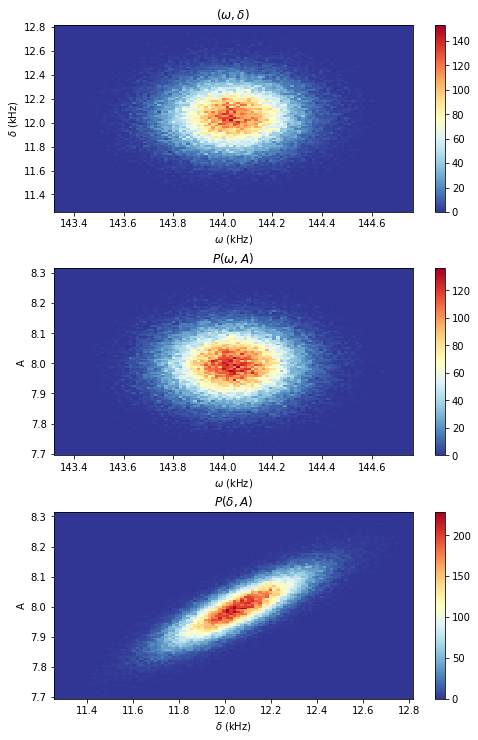

In [ ]:
plt.figure(figsize=(8, 12))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.9, top=0.9, wspace=0.2,hspace=0.3)

plt.subplot(311)
h = plt.hist2d(o_toy, d_toy, 100, cmap="RdYlBu_r")
plt.colorbar(h[3])
plt.title("$(\omega, \delta)$")
plt.xlabel("$\omega$ (kHz)")
plt.ylabel("$\delta$ (kHz)")


plt.subplot(312)
h = plt.hist2d(o_toy, a_toy, 100, cmap="RdYlBu_r")
plt.colorbar(h[3])
plt.title("$P (\omega, A)$")
plt.xlabel("$\omega$ (kHz)")
plt.ylabel("A")


plt.subplot(313)
h = plt.hist2d(d_toy, a_toy, 100, cmap="RdYlBu_r")
plt.colorbar(h[3])
plt.title("$P (\delta, A)$")
plt.xlabel("$\delta$ (kHz)")
plt.ylabel("A")

In [ ]:
n_data = len(o_toy)
alpha = 1.55

#Conta elementi dentro ellisse o-d
in_od = 0
for i in range(n_data):
    if ((o_toy[i]-popt[1])**2/(alpha*perr[1])**2 + (d_toy[i]-popt[2])**2/(alpha*perr[2])**2) < 1: in_od += 1
print("Prob = " + str(in_od/n_data) + ", atteso = 0.68")

#Conta elementi dentro ellisse o-a
in_oa = 0
for i in range(n_data):
    if ((o_toy[i]-popt[1])**2/(alpha*perr[1])**2 + (a_toy[i]-popt[0])**2/(alpha*perr[0])**2) < 1: in_oa += 1
print("Prob = " + str(in_oa/n_data) + ", atteso = 0.68")

#Conta elementi dentro ellisse roto-traslata d-a
in_da = 0
for i in range(n_data):
    beta = np.arctan(perr[0]/perr[2])
    x = (d_toy[i]-popt[2])*np.cos(beta) - (a_toy[i]-popt[0])*np.sin(beta) + popt[2]
    y = (d_toy[i]-popt[2])*np.sin(beta) + (a_toy[i]-popt[0])*np.sin(beta) + popt[0]
    if ((x-popt[2])**2/(alpha*perr[2])**2 + (y-popt[0])**2/(alpha*perr[0])**2) < 1: in_da += 1
print("Prob = " + str(in_da/n_data) + ", atteso = 0.68")


Prob = 0.69871, atteso = 0.68
Prob = 0.69866, atteso = 0.68
Prob = 0.69872, atteso = 0.68
